In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
#from keras import callbacks
import numpy as np
import glob as glob
from skimage import color
from skimage import io
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [31]:
# dimensions of our images.
img_width, img_height = 256, 256

train_data_dir = '../data/model/key16/train'
validation_data_dir = '../data/model/key16/validation'
nb_train_samples = int(len(glob.glob(train_data_dir+'/*/*.png')))
nb_validation_samples = int(len(glob.glob(validation_data_dir+'/*/*.png')))
epochs = 150
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [32]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.5))

model.add(Conv2D(34, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

model.add(Conv2D(34, (8, 8)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))

AdamOpt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=AdamOpt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
activation_11 (Activation)   (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 80, 80, 34)        54434     
_________________________________________________________________
activation_12 (Activation)   (None, 80, 80, 34)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 34)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 34)        0         
__________

In [37]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    plt.figure()
    imgplot = plt.imshow(img)
    plt.show()
    img = color.rgb2gray(img)
    img = exposure.equalize_adapthist(img)
    return img

In [38]:
train_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_img)

validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_img)

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_img)

In [39]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3185 images belonging to 6 classes.


In [40]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 637 images belonging to 6 classes.


Epoch 1/150


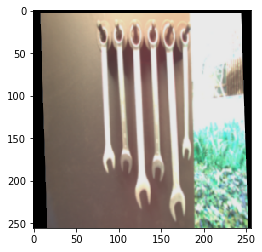

c:\02456_deeplearning\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
Exception in thread Thread-79:
Traceback (most recent call last):
  File "c:\02456_deeplearning\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\02456_deeplearning\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\02456_deeplearning\lib\site-packages\keras\utils\data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "c:\02456_deeplearning\lib\site-packages\keras\preprocessing\image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "c:\02456_deeplearning\lib\site-packages\keras\preprocessing\image.py", line 1037, in next
    batch_x[i] = x
ValueError: could not broadcast input array from shape (256,256) into shape (256,256,3)



StopIteration: 

In [41]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, verbose=1)

In [14]:
loss, accuracy = model.evaluate_generator(validation_generator, 
                                steps = nb_validation_samples // batch_size)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)


Test Loss: 0.819874272349
Test Accuracy 0.760064412622


In [15]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

valid_pred_prob = model.predict_generator(validation_generator,steps = nb_validation_samples // batch_size, verbose=1)
valid_pred_labels = np.argmax(valid_pred_prob, axis=-1)

Found 637 images belonging to 6 classes.
39/39 [==============================] - 2s     


In [16]:
acc = 1-np.sum(valid_pred_labels!=validation_generator.classes[0:valid_pred_labels.shape[0]])/valid_pred_labels.shape[0]
acc

0.76762820512820507

In [22]:
#model.save('../saved_weights/CNN_key16')

# Test data validation

In [26]:
test_data_dir = '../data/model/key16/test'
nb_test_samples = int(len(glob.glob(test_data_dir+'/*/*.png')))


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

test_pred_prob = model.predict_generator(test_generator,steps = 128 // 1, verbose=1)
test_pred_labels = np.argmax(test_pred_prob, axis=-1)

Found 128 images belonging to 6 classes.
125/128 [============================>.] - ETA: 0s

In [27]:
acc = 1-np.sum(test_pred_labels!=test_generator.classes)/nb_test_samples
acc

0.515625

pos1\16_17_18_19_22_24_H_H_L_L_L_H_21_0_992.png


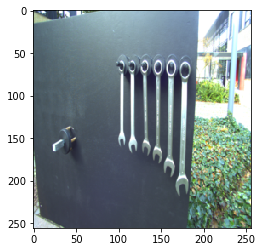

pos1\16_19_22_17_18_24_L_L_L_H_H_H_57_0_3240.png


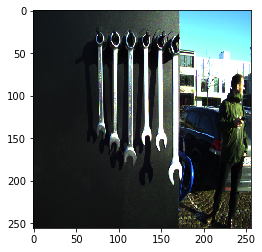

pos1\16_19_22_17_18_24_L_L_L_H_H_H_58_0_6871.png


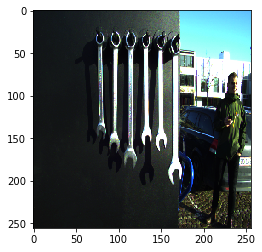

pos1\16_19_22_17_18_24_L_L_L_H_H_H_62_0_4565.png


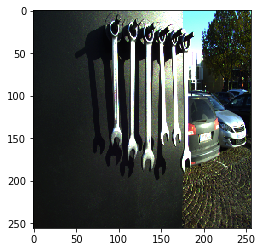

pos1\16_19_22_17_18_24_L_L_L_H_H_H_62_0_456522222.png


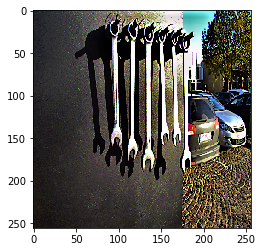

pos1\16_19_22_17_18_24_L_L_L_H_H_H_68_0_5614.png


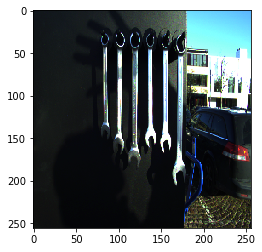

pos1\16_19_22_17_18_24_L_L_L_H_H_H_69_0_3363.png


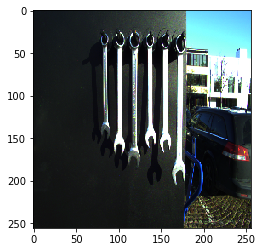

pos1\16_24_18_22_17_19_H_H_L_L_H_H_12_0_4785.png


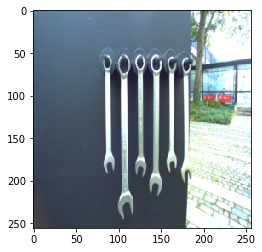

pos1\16_24_18_22_17_19_H_H_L_L_H_H_5_0_9302.png


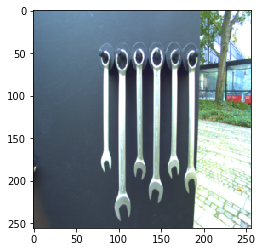

pos1\16_24_22_17_18_19_L_H_L_H_H_L_50_0_6393.png


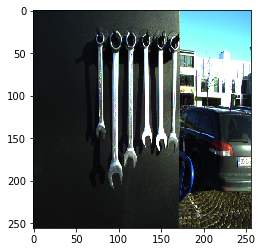

pos1\16_24_22_17_18_19_L_H_L_H_H_L_51_0_4695.png


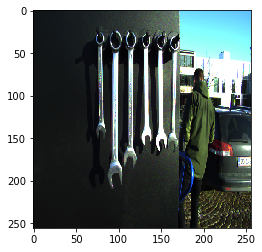

pos1\16_24_22_17_18_19_L_H_L_H_H_L_52_0_7313.png


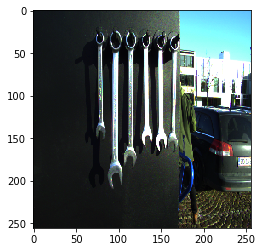

pos1\16_24_22_17_18_19_L_H_L_H_H_L_53_0_7921.png


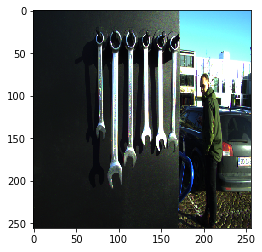

pos1\16_24_22_17_18_19_L_H_L_H_H_L_54_0_9458.png


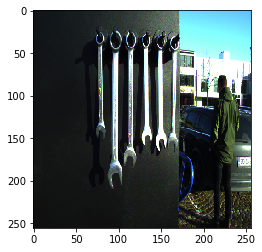

pos1\16_24_22_17_18_19_L_H_L_H_H_L_55_0_3102.png


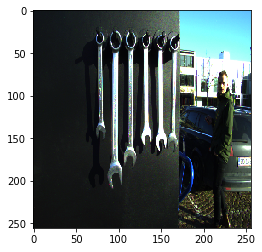

pos2\17_16_18_19_22_24_H_H_L_H_H_H_104_0_9377.png


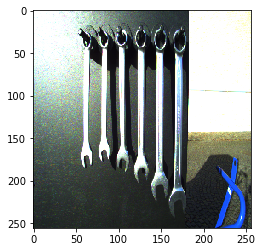

pos2\17_16_18_19_22_24_H_H_L_H_H_H_109_0_7086.png


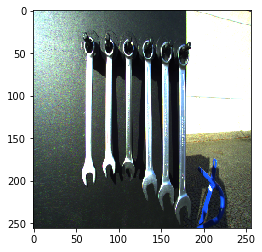

pos2\17_16_18_22_24_19_L_L_L_L_H_L_0597_0_9963.png


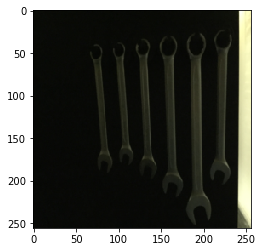

pos2\24_16_18_19_22_17_H_L_H_L_L_H_32_0_4865.png


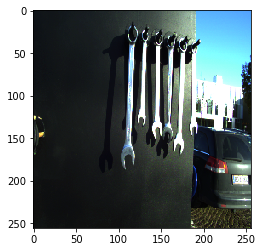

pos2\24_16_22_17_18_19_H_H_L_H_L_H_0577_0_8822.png


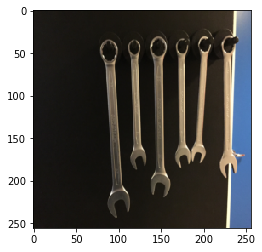

pos2\24_16_22_18_17_19_H_L_H_H_H_L_141_0_5183.png


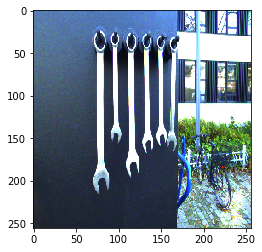

pos3\17_22_16_24_18_19_H_L_H_H_L_L_0681_0_6841.png


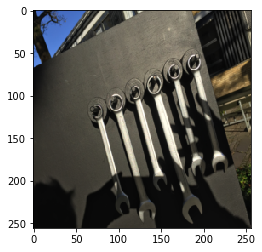

pos3\17_24_16_22_18_19_H_H_L_L_H_L_100_0_5361.png


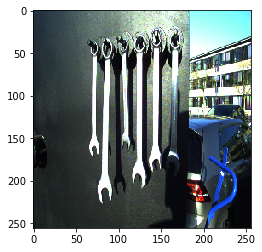

pos3\17_24_16_22_18_19_H_H_L_L_H_L_102_0_7752.png


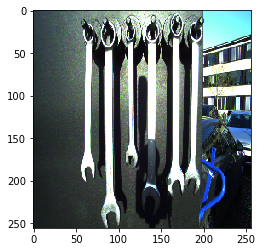

pos3\17_24_16_22_18_19_H_H_L_L_H_L_97_0_603.png


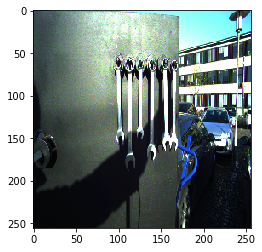

pos3\19_24_16_18_22_17_L_L_L_H_L_L_4_0_1689.png


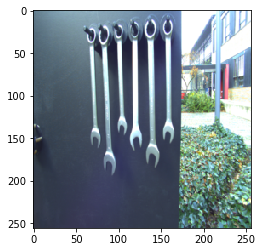

pos4\17_18_19_16_24_22_H_L_L_L_H_L_7_0_54.png


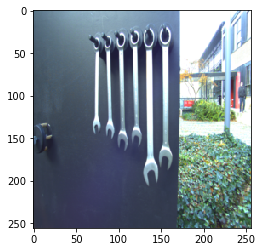

pos4\17_18_19_16_24_22_H_L_L_L_H_L_9_0_2780.png


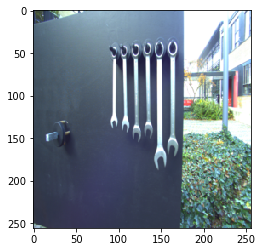

pos4\17_19_22_16_18_24_H_L_L_L_H_H_71_0_1526.png


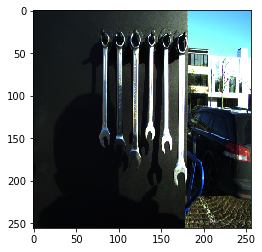

pos4\17_19_22_16_18_24_H_L_L_L_H_H_72_0_8369.png


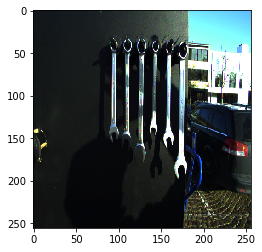

pos4\17_19_22_16_18_24_H_L_L_L_H_H_73_0_4905.png


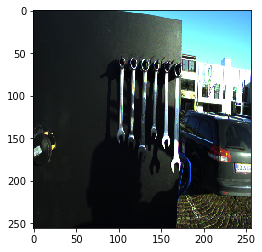

pos4\17_19_22_16_18_24_H_L_L_L_H_H_74_0_8372.png


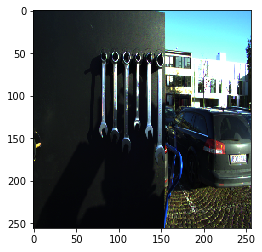

pos4\17_19_22_16_18_24_H_L_L_L_H_H_77_0_649.png


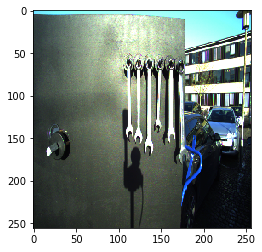

pos4\17_19_22_16_18_24_H_L_L_L_H_H_78_0_2134.png


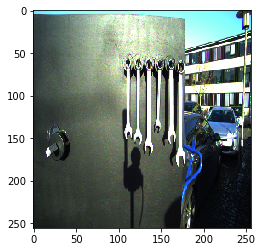

pos4\17_19_22_16_18_24_H_L_L_L_H_H_79_0_6038.png


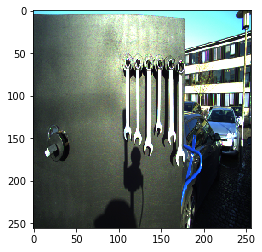

pos4\17_19_22_16_18_24_H_L_L_L_H_H_80_0_2465.png


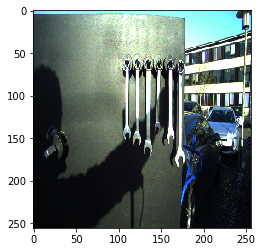

pos4\17_24_22_16_18_19_H_H_L_L_H_L_82_0_9936.png


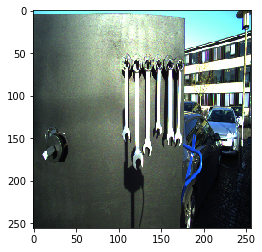

pos4\17_24_22_16_18_19_H_H_L_L_H_L_86_0_1228.png


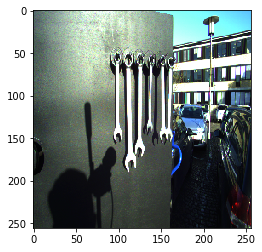

pos4\17_24_22_16_18_19_H_H_L_L_H_L_88_0_3219.png


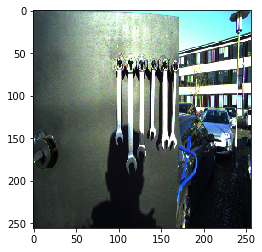

pos4\17_24_22_16_18_19_H_H_L_L_H_L_89_0_3535.png


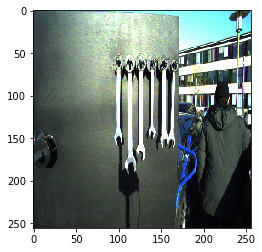

pos4\17_24_22_16_18_19_H_H_L_L_H_L_90_0_7784.png


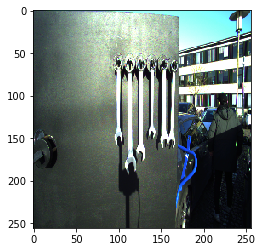

pos4\17_24_22_16_18_19_H_H_L_L_H_L_91_0_1607.png


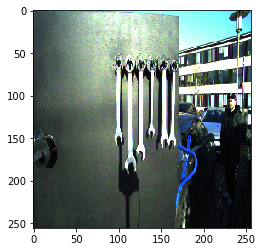

pos4\17_24_22_16_18_19_H_H_L_L_H_L_92_0_1778.png


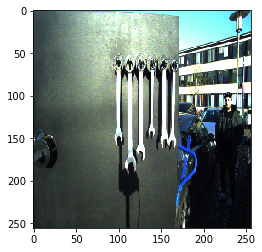

pos5\17_22_18_19_16_24_H_H_L_H_H_H_110_0_7817.png


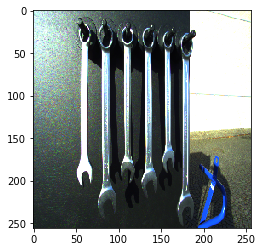

pos5\17_22_18_19_16_24_H_H_L_H_H_H_111_0_1469.png


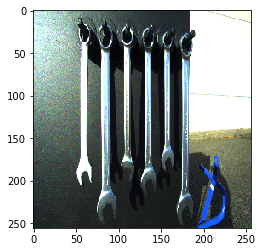

pos5\17_22_18_19_16_24_H_H_L_H_H_H_112_0_976.png


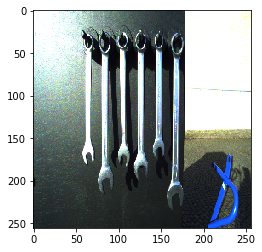

pos5\17_22_18_19_16_24_H_H_L_H_H_H_113_0_7696.png


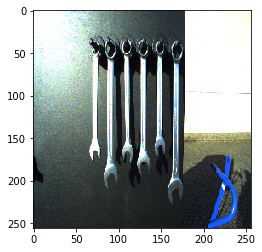

pos5\17_22_18_19_16_24_H_H_L_H_H_H_114_0_3515.png


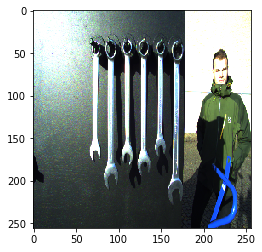

pos5\17_22_18_19_16_24_H_H_L_H_H_H_115_0_8852.png


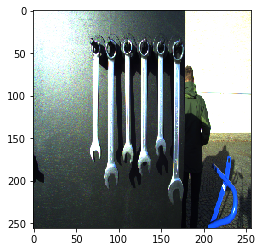

pos5\17_22_18_19_16_24_H_H_L_H_H_H_117_0_5080.png


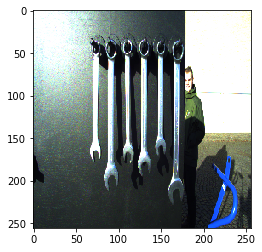

pos5\17_22_18_19_16_24_H_H_L_H_H_H_118_0_639.png


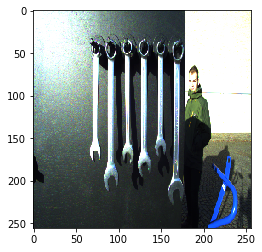

pos5\18_22_17_19_16_24_L_H_H_H_H_H_119_0_3287.png


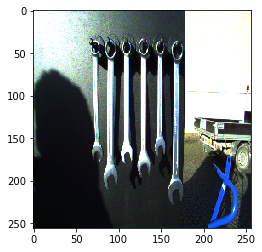

pos5\18_22_17_19_16_24_L_H_H_H_H_H_120_0_5837.png


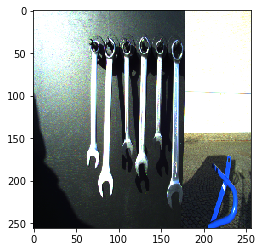

pos5\18_22_17_19_16_24_L_H_H_H_H_H_121_0_4195.png


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


pos5\18_22_17_19_16_24_L_H_H_H_H_H_126_0_4199.png


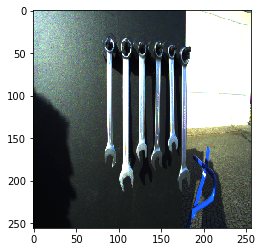

pos5\18_22_17_19_16_24_L_H_H_H_H_H_127_0_1115.png


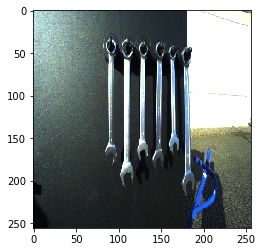

pos5\18_22_17_19_16_24_L_H_H_H_H_H_130_0_4038.png


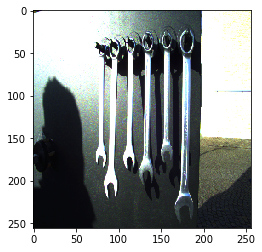

pos5\18_22_17_19_16_24_L_L_L_L_H_H_15_0_1438.png


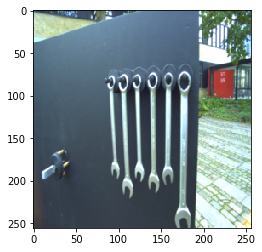

pos6\19_22_18_24_17_16_H_L_L_H_H_H_1_0_9057.png


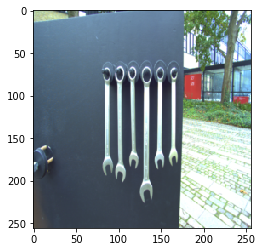

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
idx = np.array(np.where(test_pred_labels!=test_generator.classes))
for i in range(0,idx.shape[1]):
    print(test_generator.filenames[idx[0,i]])
    imgs=mpimg.imread(test_data_dir+'/'+test_generator.filenames[idx[0,i]])
    plt.figure()
    imgplot = plt.imshow(imgs)
    plt.show()